## The models were trained on Google Colab

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
!pip install scikit-plot

In [0]:
import copy
import warnings
import pydotplus
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
%config InlineBackend.figure_format='retina'

In [0]:
from sklearn.model_selection import (learning_curve, RandomizedSearchCV,
                                     StratifiedShuffleSplit, StratifiedKFold,
                                     train_test_split,
                                    )
from sklearn.metrics import (accuracy_score, average_precision_score,
                             classification_report, confusion_matrix,
                             f1_score, precision_recall_curve,
                             precision_score, recall_score, 
                             roc_auc_score, roc_curve,
                            )
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import  MinMaxScaler
from sklearn.utils.class_weight import (compute_class_weight,
                                        compute_sample_weight)
from sklearn.base import clone
from scikitplot.metrics import plot_precision_recall
from joblib import dump, load
from io import StringIO
from ipywidgets import Image

In [0]:
def feature_engineering(df):
   """Perform feature engineering:
    a) create binary feature for 99.99 frauds taken in groups;
    b) take log(1+a) of Amount;
    c) perform sine and cosine transformation of "seconds after midnight";
    d) transform "seconds after midnight" to [0,1].
    """

    # 99.99 frauds taken in groups
    df_new = df.sort_values(["Time", "V1"])
    df_new = df_new[(df_new["Amount"] == 99.99)]
    df_new["diff"] = df_new["Time"].diff()
    diff = df_new["diff"]
    df = df.join(diff)
    df["Amount_99_group"] = (df["diff"] < 40).astype(int)
    df.drop("diff", axis=1, inplace=True)
    
    # Log transform of Amount
    df["Amount"] = np.log1p(df["Amount"])
    
    # Sine and cosine transformation of time
    seconds_in_day = 86400
    df["Time"] = df["Time"] % seconds_in_day  # "seconds after midnight"
    df["Sin_time"] = np.sin(2*np.pi*df["Time"] / seconds_in_day)
    df["Cos_time"] = np.cos(2*np.pi*df["Time"] / seconds_in_day)
    
    # Transform "seconds after midnight"
    min_max_scaler = MinMaxScaler()
    df["Time"] = min_max_scaler.fit_transform(np.array(df.loc[:, "Time"]).reshape(-1,1))

    return df 

In [0]:
def feature_engineering_2(df):
    """Perform feature engineering:
    a) take log(1+a) of Amount;
    b) perform sine and cosine transformation of "seconds after midnight";
    c) transform "seconds after midnight" to [0,1];
    d) drop least important features.
    """
    
    # Log transform of Amount
    df["Amount"] = np.log1p(df["Amount"])
    
    # Sine and cosine transformation of time
    seconds_in_day = 86400
    df["Time"] = df["Time"] % seconds_in_day  # "seconds after midnight"
    df["Sin_time"] = np.sin(2*np.pi*df["Time"] / seconds_in_day)
    df["Cos_time"] = np.cos(2*np.pi*df["Time"] / seconds_in_day)
    
    # Transform "seconds after midnight"
    min_max_scaler = MinMaxScaler()
    df["Time"] = min_max_scaler.fit_transform(np.array(df.loc[:, "Time"]).reshape(-1,1))

    # Drop least important features
    df.drop(["V13", "V15", "V23", "V25"], axis=1, inplace=True)
    
    return df

In [0]:
def set_threshold(model, X_test, y_test):
  """Function for setting optimal threshold for trained model.
  Returns optimal threshold, best score and dictionary containing
  scores for each threshold.
  """

  best_score = 0
  best_thresh = 0
  dic = dict()
  y_proba = model.predict_proba(X_test)

  for threshold in np.arange(0.01, 1, 0.01):
    y_test_threshold = (y_proba[:, 1] >= threshold).astype(int)
    av_prec = average_precision_score(y_test, y_test_threshold)
    dic[threshold] = av_prec
    if av_prec > best_score:
      best_score = av_prec
      best_thresh = threshold
      
  return best_thresh, best_score, dic

In [0]:
def plot_importances(est, columns):
  """Show importance of each feature used in a model
  """
    columns = df.drop(["Class"], axis=1).columns
    importances = est.feature_importances_
    
    fig, ax = plt.subplots(figsize=(10,8))
    ax.barh(columns, importances)
    ax.set_title("{} feature importances".format(type(est).__name__))
    
    return fig

In [0]:
df = pd.read_csv("/content/drive/My Drive/data1.csv")
df.drop(df.columns[0], inplace=True, axis=1)  # Drop first column (index)
df = feature_engineering(df)  # performing "first" feature engineering

In [0]:
X = df.loc[:, df.columns != "Class"]  # select features for predicting Class
X = X.astype("float32")  # convert the chosen features to float32 type
y = df["Class"]  # target column
y = y.astype("int32")
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2019,
                                                    stratify=y)
# Stratified cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2019)

XGBOOST, default model with weights

In [251]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Amount_99_group,Sin_time,Cos_time
0,0.477025,2.004188,-0.287498,-1.984934,0.342239,0.413188,-0.815346,0.445456,-0.299258,0.562445,0.109932,-1.381862,-0.428037,-1.230877,0.629740,-0.242149,-0.388169,-0.137390,-0.552790,0.315548,-0.152272,-0.038661,-0.127194,0.036464,0.504076,0.176423,0.541252,-0.121212,-0.064948,4.189503,0,0,0.143924,-0.989589
1,0.613313,2.346905,-1.264915,-1.034900,-1.568721,-1.122435,-0.790624,-1.011732,-0.268243,-1.229191,1.576645,-1.286030,-0.816409,0.603102,-0.437890,-0.164642,-0.582255,0.427399,-0.134499,-0.049048,-0.460329,-0.196288,0.015015,0.197023,-0.432445,-0.119139,-0.131627,0.015176,-0.058104,0.693147,0,0,-0.653255,-0.757138
2,0.792634,-3.089671,2.464689,0.042745,1.670674,-2.129076,0.600262,-1.627285,2.452801,0.319063,-0.526330,-1.681347,1.951140,1.001432,0.346440,-1.625289,-1.128464,1.888585,-1.045530,1.149074,-0.060298,-0.223384,-0.441265,0.250283,0.091483,-0.038373,-0.410096,0.088944,0.026973,3.456317,0,0,-0.964365,0.264574
3,0.431457,1.792358,-0.384458,-2.170063,0.096243,0.291162,-1.510182,0.921037,-0.525263,-0.088484,0.119203,1.171025,1.013250,-0.123025,1.041171,-0.323426,-0.460035,-0.465857,-0.061338,0.309959,0.072457,0.297749,0.633531,-0.176001,0.146116,0.342753,0.198887,-0.117734,-0.061706,5.044006,0,0,0.417537,-0.908660
4,0.403042,2.188008,-0.400212,-1.627908,-0.225692,-0.133549,-1.273351,0.226144,-0.553975,-0.908684,0.877520,-0.845913,0.763512,1.478457,0.027869,-0.734253,-2.244708,0.184697,0.251184,-0.646467,-0.558023,-0.338599,-0.220436,0.112804,0.049313,0.157236,0.606729,-0.063450,-0.071105,2.397895,0,0,0.572265,-0.820069


In [0]:
# train default model with weights (to compensate class imbalance)
df_frauds = df[df["Class"] == 1]
df_non_frauds = df[df["Class"] == 0]
scale_pos_weight = np.sqrt(df_non_frauds.shape[0] / df_frauds.shape[0])
model = xgb.XGBClassifier(random_state=2019, tree_method="gpu_hist",
                            scale_pos_weight=scale_pos_weight)

In [0]:
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)

In [254]:
# AUPRC
average_precision_score(y_test, y_proba[:,1])

0.8238649119319765

In [0]:
best_thresh, best_score, dic = set_threshold(model, X_test, y_test)

In [256]:
best_thresh, best_score  # set best threshold

(0.9500000000000001, 0.7400658448183494)

In [0]:
y_test_threshold = (y_proba[:,1]>=best_thresh).astype(int)

In [258]:
print(classification_report(y_test, y_test_threshold))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63971
           1       0.97      0.77      0.85       111

    accuracy                           1.00     64082
   macro avg       0.98      0.88      0.93     64082
weighted avg       1.00      1.00      1.00     64082



In [259]:
confusion_matrix(y_test, y_test_threshold)

array([[63968,     3],
       [   26,    85]])

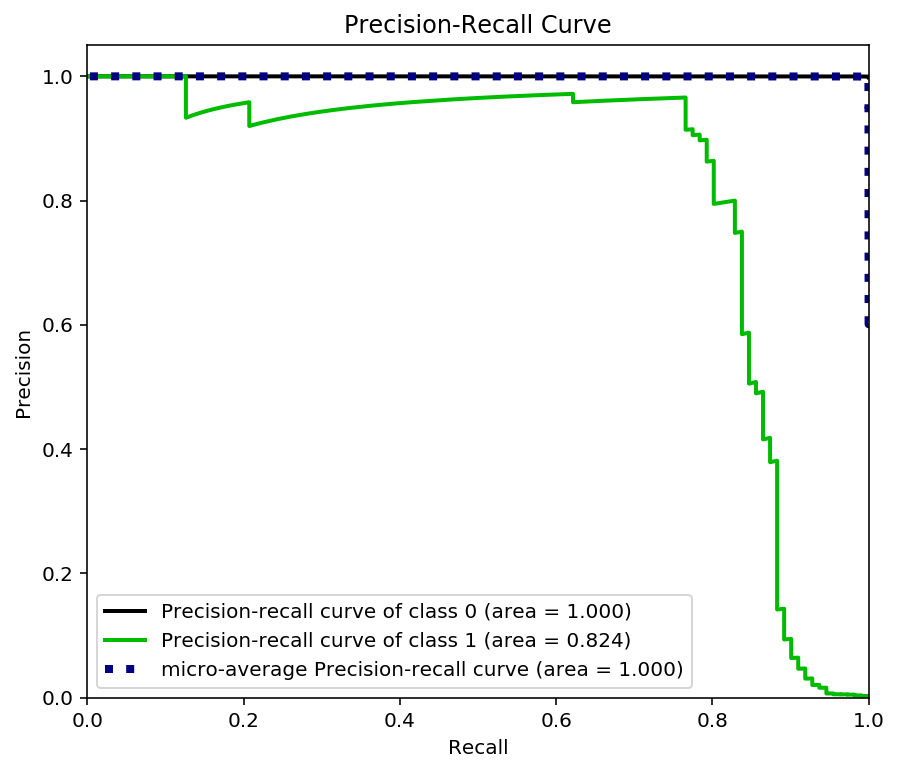

In [260]:
plot_precision_recall(y_test, y_proba, figsize=(7,6));

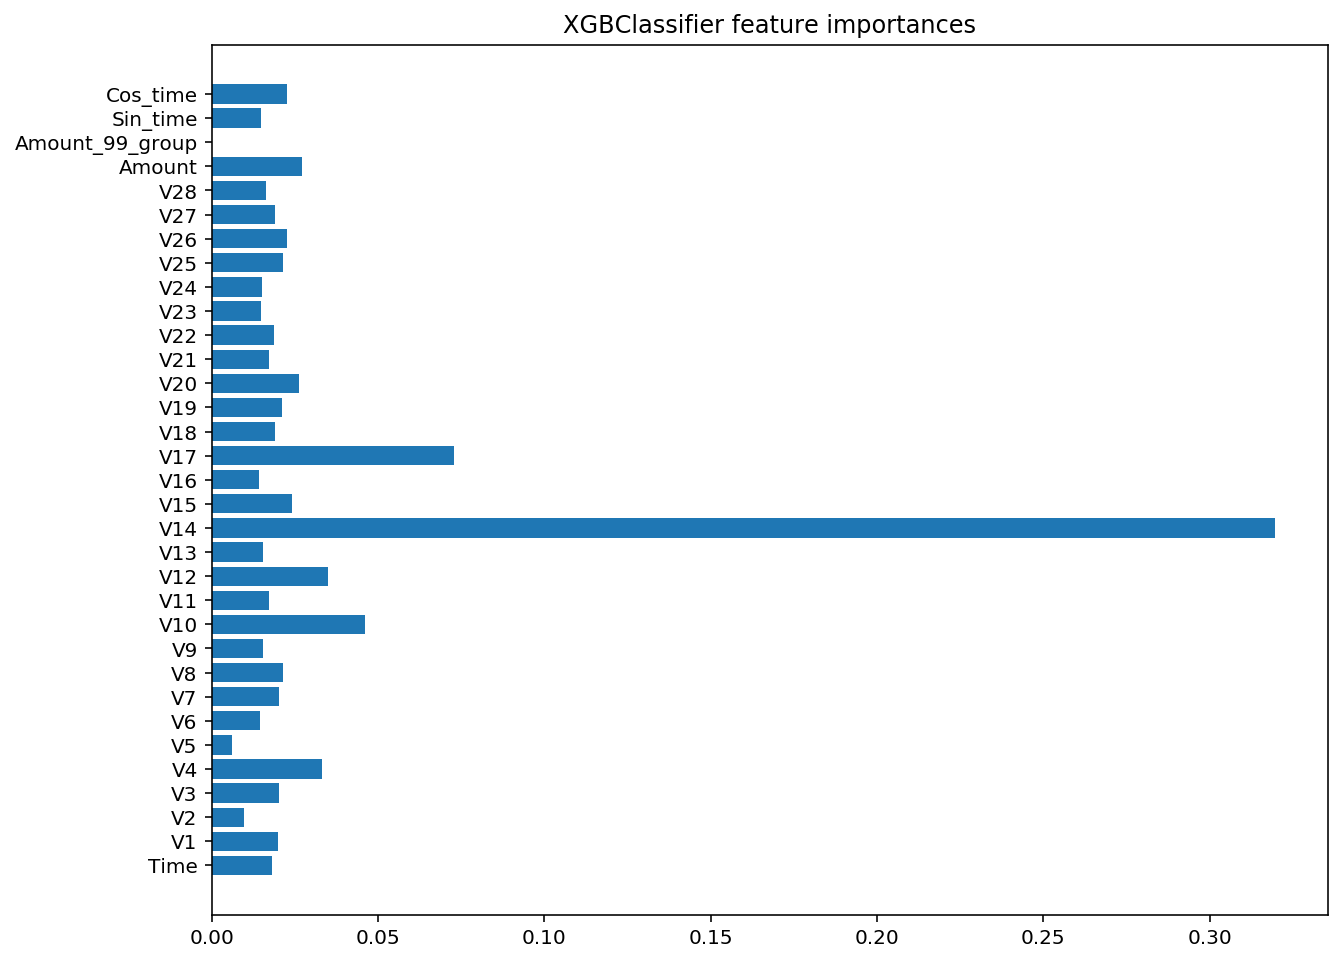

In [261]:
fig = plot_importances(model)

In [262]:
threshold = best_thresh
check_cost = 0.5
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
overall_cost = (np.sum(X_test[(y_test == 1) & (y_pred == 0)]["Amount"]) \
+ fp * check_cost \
+ tp * check_cost)

print("Cost with {} threshold: {}".format(threshold, overall_cost))

Cost with 0.9500000000000001 threshold: 111.49856185913086


## Tuning XGBOOST model parameters and using second function for feature engineering 

In [0]:
df = pd.read_csv("/content/drive/My Drive/data1.csv")
df.drop(df.columns[0], inplace=True, axis=1)  # Drop first column (index)
df = feature_engineering_2(df)  # performing "first" feature engineering

In [0]:
X = df.loc[:, df.columns != "Class"]  # select features for predicting Class
X = X.astype("float32")  # convert the chosen features to float32 type
y = df["Class"]  # target column
y = y.astype("int32")
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2019,
                                                    stratify=y)

In [0]:
params_1 =  {"max_depth": np.arange(2,15), "learning_rate": np.arange(0.01,0.5,0.02),
         "n_estimators": np.arange(1000,2050,50), "subsample": np.arange(0.7, 1.0, 0.05),
          'reg_alpha': [0.001, 0.005, 0.01, 0.05, 0.5, 1, 5],
          "gamma": np.arange(1, 7, 0.2), "colsample_bytree": np.arange(0.3, 1.0, 0.05)}


In [229]:
grid_xgb = RandomizedSearchCV(model, params_1, n_iter=5, n_jobs=-1,
                          scoring="average_precision", cv=skf, verbose=1)
grid_xgb.fit(X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.8min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2019, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=N...
                                        'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_estimators': array([1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500,
       1550, 1600, 1650, 1700, 1750, 1800, 1850

In [230]:
results = pd.DataFrame(grid_xgb.cv_results_).sort_values("rank_test_score")
results = results.reset_index(drop=True)
results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_alpha,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,7.465282,0.066822,0.016792,0.000518,0.75,0.01,1200,10,0.39,6.8,0.9,"{'subsample': 0.75, 'reg_alpha': 0.01, 'n_esti...",0.887996,0.923167,0.938052,0.645290,0.868368,0.880745,0.788886,0.796925,0.849671,0.892978,0.847208,0.081279,1
1,10.418993,0.471519,0.019089,0.001989,0.9,0.05,1400,5,0.07,4.8,0.8,"{'subsample': 0.9000000000000001, 'reg_alpha':...",0.887994,0.924191,0.936393,0.632189,0.872672,0.877635,0.796408,0.808982,0.834562,0.887086,0.845811,0.083142,2
2,8.758471,0.192737,0.018177,0.002907,0.85,0.05,1450,9,0.49,3.6,0.6,"{'subsample': 0.8500000000000001, 'reg_alpha':...",0.883616,0.912157,0.935292,0.649641,0.868407,0.866512,0.799657,0.810232,0.823131,0.881492,0.843014,0.076399,3
3,8.447700,0.098961,0.018009,0.000452,0.9,0.005,1450,3,0.43,4,0.85,"{'subsample': 0.9000000000000001, 'reg_alpha':...",0.891167,0.909856,0.931885,0.634217,0.869911,0.860139,0.780788,0.815575,0.834176,0.883660,0.841137,0.081006,4
4,9.332909,0.167439,0.017009,0.002334,0.8,1,1700,3,0.49,1.6,0.8,"{'subsample': 0.8, 'reg_alpha': 1, 'n_estimato...",0.883343,0.916256,0.921939,0.626120,0.867487,0.878163,0.769136,0.798553,0.815729,0.884178,0.836090,0.084554,5


In [231]:
grid_xgb.best_score_

0.8472077076399046

In [232]:
 grid_xgb.best_params_

{'colsample_bytree': 0.8999999999999999,
 'gamma': 6.799999999999999,
 'learning_rate': 0.38999999999999996,
 'max_depth': 10,
 'n_estimators': 1200,
 'reg_alpha': 0.01,
 'subsample': 0.75}

In [0]:
best_model =  grid_xgb.best_estimator_

In [0]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

In [235]:
average_precision_score(y_test, y_proba)

0.8551265967792931

In [236]:
f1_score(y_test, y_pred)

0.8792270531400965

In [237]:
confusion_matrix(y_test, y_pred)

array([[63966,     5],
       [   20,    91]])

In [238]:
best_thresh, best_score, dic_score = set_threshold(best_model,
                                          X_test,
                                          y_test)
best_thresh, best_score                                  

(0.09999999999999999, 0.7896312947217083)

In [0]:
dic_score

In [0]:
y_proba = best_model.predict_proba(X_test)[:,1]
y_test_threshold = (y_proba >= best_thresh).astype(int)

In [241]:
average_precision_score(y_test, y_test_threshold)

0.7896312947217083

In [242]:
f1_score(y_test, y_test_threshold)

0.8878504672897196

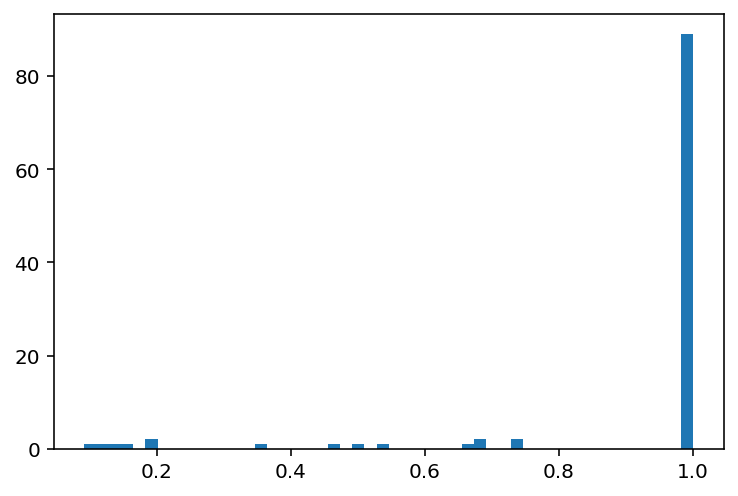

In [243]:
possible_frauds = y_proba[y_proba>0.05]
plt.hist(possible_frauds, bins=50);

In [244]:
print(classification_report(y_test, y_test_threshold))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63971
           1       0.92      0.86      0.89       111

    accuracy                           1.00     64082
   macro avg       0.96      0.93      0.94     64082
weighted avg       1.00      1.00      1.00     64082



In [245]:
confusion_matrix(y_test, y_test_threshold)

array([[63963,     8],
       [   16,    95]])

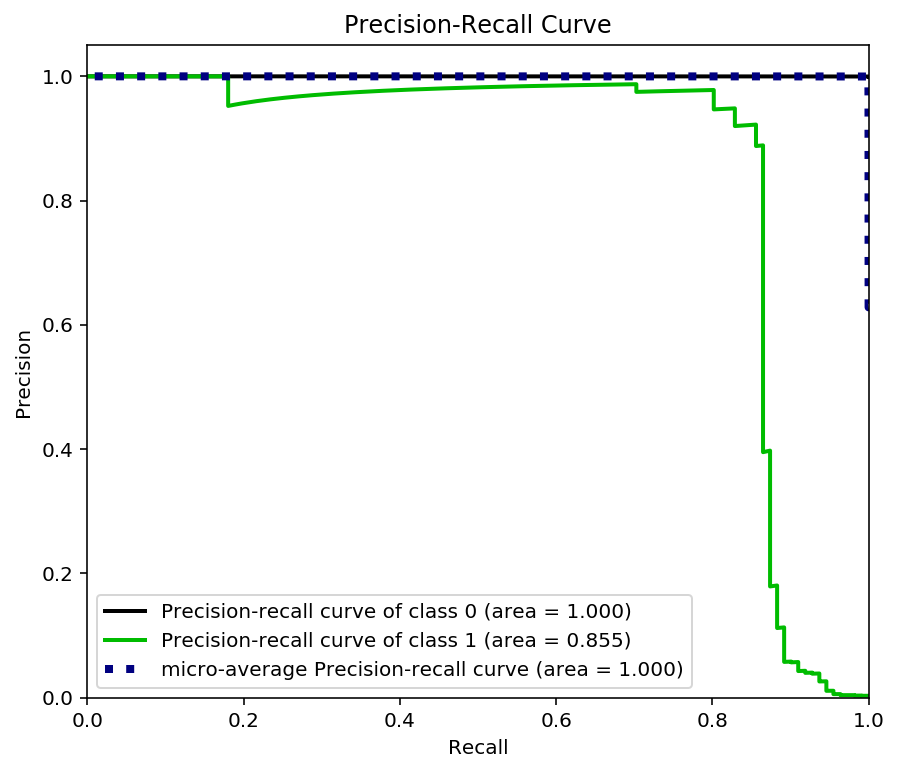

In [246]:
y_proba = best_model.predict_proba(X_test)
plot_precision_recall(y_test, y_proba, figsize=(7,6));

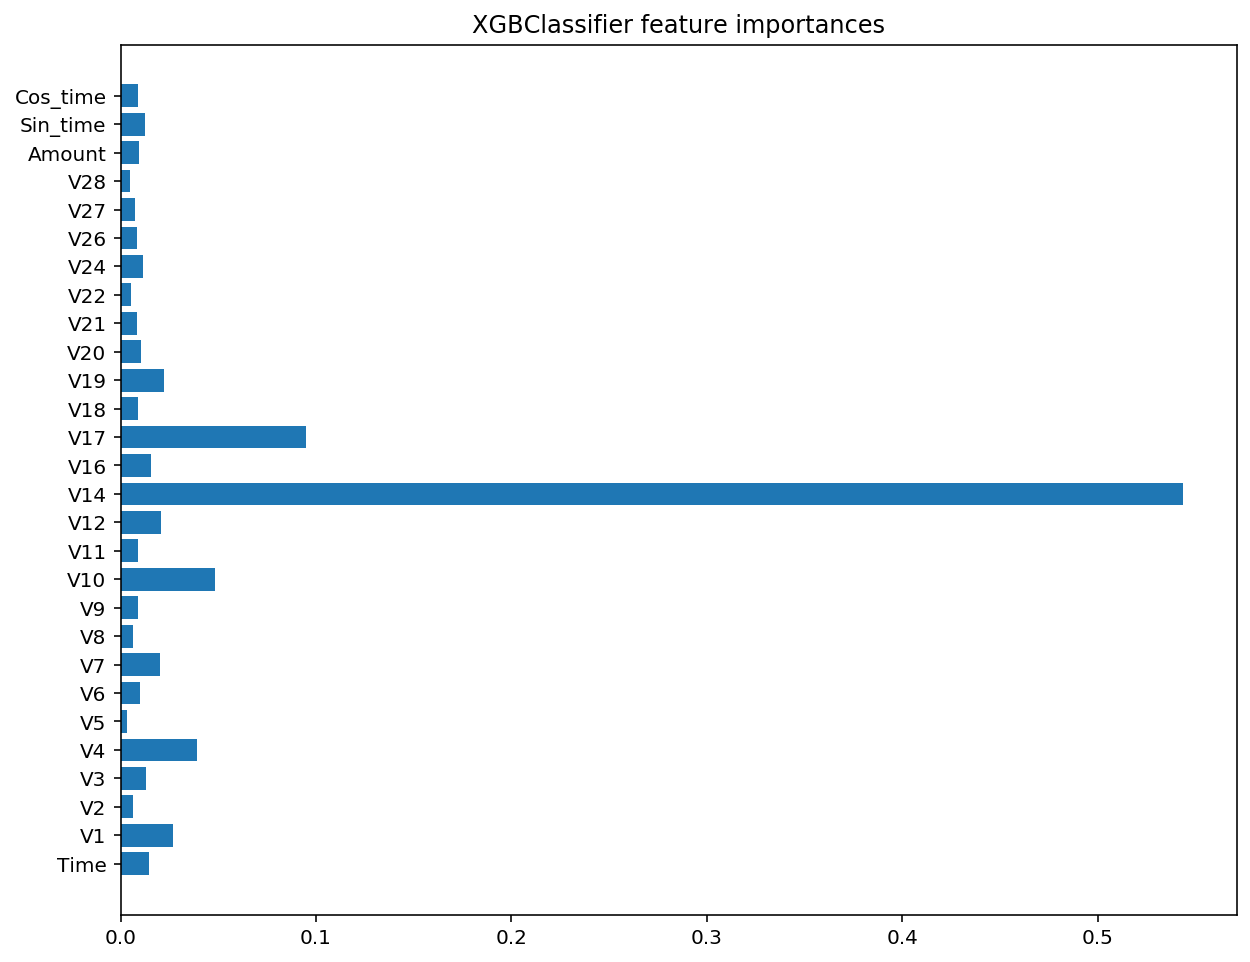

In [247]:
fig = plot_importances(best_model)

In [248]:
threshold = best_thresh
check_cost = 0.5
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
overall_cost = (np.sum(X_test[(y_test == 1) & (y_pred == 0)]["Amount"]) \
+ fp * check_cost \
+ tp * check_cost)

print("Cost with {} threshold: {}".format(threshold, overall_cost))

Cost with 0.09999999999999999 threshold: 111.49856185913086
